In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.linear_model import LogisticRegression
warnings.simplefilter(action='ignore', category=FutureWarning)

SEED = 123

In [2]:
taobao_df = pd.read_csv('taobao_sampled.csv')

In [3]:
taobao_df.shape

(250295, 21)

In [4]:
#Split dates into days for categorical encoding/create dummies
    #- Double check of outliers in prices
    #- Create dummies for shopping level 
    #- Create dummies for occupation
    #- Create dummies for new_user_class level
    #- figure out encoding function for high cardinality features

<Axes: >

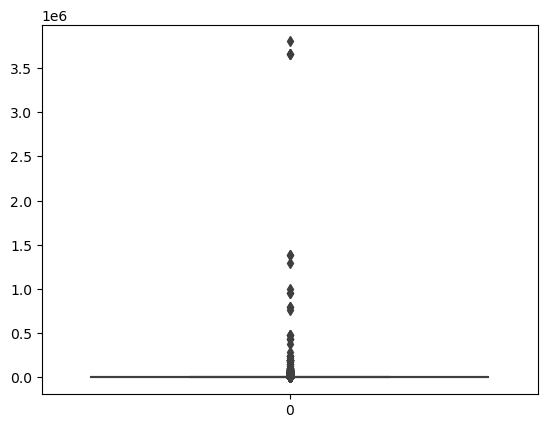

In [5]:
sns.boxplot(taobao_df['price'])

Checking to see the outliers for the price feature, looks like one purchase is way out there

In [6]:
taobao_df['price'].describe().apply(lambda x: format(x, 'f'))

count     250295.000000
mean         578.731110
std        16463.383175
min            0.010000
25%           87.480000
50%          168.000000
75%          328.000000
max      3800000.000000
Name: price, dtype: object

In [7]:
#Performing the calculations needed to determine the percentiles needed for the box plot to remove the outliers

In [8]:
percentile25 = taobao_df['price'].quantile(0.05)
percentile75 = taobao_df['price'].quantile(0.95)
iqr = percentile75 - percentile25

upper_limit = percentile25 + 1.5 * iqr
lower_limit = percentile75 - 1.5 * iqr

print(f"upper limit: {upper_limit}")
print(f"upper limit: {lower_limit}")

upper limit: 2015.21
upper limit: -645.6300000000001


In [9]:
#Removed the outliars outside the upper and lower bounds

In [10]:
taobao_df = taobao_df[(taobao_df['price'] >= lower_limit) & (taobao_df['price'] <= upper_limit)]

<Axes: >

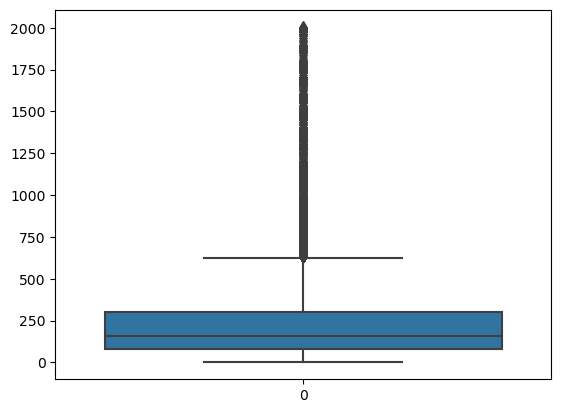

In [11]:
sns.boxplot(taobao_df['price'])

In [12]:
taobao_df.shape

(241756, 21)

We removed the most signicant outliars based on the price column, originally I thought about doing the default 25/75 quantiles as the values when doing the iqr calculation; however, I thought about how its probably not uncommon for people to spend a lot of money during a sale. I decided to set the maximum price to be around $2000, the majority of the users will spend less than this. About 90,000 entries was dropped because they were outliers. 

In [13]:
taobao_df['price'].describe().apply(lambda x: format(x, 'f'))

count    241756.000000
mean        251.464888
std         290.888279
min           0.010000
25%          80.000000
50%         159.000000
75%         299.000000
max        2008.000000
Name: price, dtype: object

In [14]:
taobao_df.head()

,Unnamed: 0.1,Unnamed: 0,adgroup_id,cate_id,campaign_id,advertiser_id,brand_id,price,user_id,time_stamp,...,clk,cms_segid,cms_group_id,gender,age_level,shopping_level,occupation,new_user_class_level,date_time,date
0,20256381,20256381,19259,10893,46151,130939,353787.0,108.0,383593,1494005921,...,0,81,10,1,4,3,0,4.0,2017-05-05 17:38:41,05-05-2017
1,22344021,22344021,326437,5920,289598,72366,454237.0,699.0,967836,1494003434,...,0,43,5,2,5,3,0,1.0,2017-05-05 16:57:14,05-05-2017
2,24549068,24549068,23637,6283,55513,138037,390418.0,176.0,350890,1494000102,...,0,90,11,1,5,3,0,1.0,2017-05-05 16:01:42,05-05-2017
3,3324928,3324928,666777,4617,83188,155813,135797.0,22.0,1083816,1494024824,...,0,20,3,2,3,3,0,4.0,2017-05-05 22:53:44,05-05-2017
4,8352008,8352008,361181,6142,172756,189104,376599.0,268.0,881369,1494000242,...,0,0,2,2,2,3,0,2.0,2017-05-05 16:04:02,05-05-2017


Creating a new column to store the time and day of the 'date_time' column, since the month and year doesnt change we dont need a seperate column for them

In [15]:
taobao_df['time'] = pd.to_datetime(taobao_df['date_time']).dt.time
taobao_df['day'] = pd.to_datetime(taobao_df['date_time']).dt.day

In [16]:
taobao_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'adgroup_id', 'cate_id', 'campaign_id',
       'advertiser_id', 'brand_id', 'price', 'user_id', 'time_stamp', 'pid',
       'clk', 'cms_segid', 'cms_group_id', 'gender', 'age_level',
       'shopping_level', 'occupation', 'new_user_class_level', 'date_time',
       'date', 'time', 'day'],
      dtype='object')

In [17]:
#Deleting date_time column along with the index columns since we dont need them anymore

In [18]:
taobao_df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'date_time'], axis=1, inplace=True)

In [19]:
taobao_df.head()

,adgroup_id,cate_id,campaign_id,advertiser_id,brand_id,price,user_id,time_stamp,pid,clk,cms_segid,cms_group_id,gender,age_level,shopping_level,occupation,new_user_class_level,date,time,day
0,19259,10893,46151,130939,353787.0,108.0,383593,1494005921,430548_1007,0,81,10,1,4,3,0,4.0,05-05-2017,17:38:41,5
1,326437,5920,289598,72366,454237.0,699.0,967836,1494003434,430539_1007,0,43,5,2,5,3,0,1.0,05-05-2017,16:57:14,5
2,23637,6283,55513,138037,390418.0,176.0,350890,1494000102,430548_1007,0,90,11,1,5,3,0,1.0,05-05-2017,16:01:42,5
3,666777,4617,83188,155813,135797.0,22.0,1083816,1494024824,430539_1007,0,20,3,2,3,3,0,4.0,05-05-2017,22:53:44,5
4,361181,6142,172756,189104,376599.0,268.0,881369,1494000242,430539_1007,0,0,2,2,2,3,0,2.0,05-05-2017,16:04:02,5


In [20]:
taobao_df['new_user_class_level'] = taobao_df['new_user_class_level'].astype(int)
taobao_df['brand_id'] = taobao_df['brand_id'].astype(int)

In [21]:
taobao_df['new_user_class_level'].dtype

dtype('int32')

In [22]:
#Create dummies for shopping level
#Create dummies for shopping level 
#Create dummies for occupation
#Create dummies for new_user_class level

In [23]:
cols_to_dummy = ['shopping_level', 'occupation' , 'age_level', 'new_user_class_level', 'gender', 'day']
prefix = cols_to_dummy[:]

taobao_df = pd.get_dummies(taobao_df, prefix=prefix, prefix_sep='_', columns=cols_to_dummy, drop_first=True)

In [24]:
# logit = LogisticRegression(random_state=SEED)
# y=taobao_df['clk']
# train = taobao_df[['adgroup_id', 'cate_id', 'campaign_id', 'advertiser_id', 'brand_id', 'user_id', 'pid']]
# columns = [i for i in X_train.columns]

# X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=SEED)

In [25]:
# targ_enc = TargetEncoder(cols=columns, smoothing=8, min_samples_leaf=5).fit(X_train, y_train)
# X_train_te = targ_enc.transform(X_train.reset_index(drop=True))
# X_val_te = targ_enc.transform(X_val.reset_index(drop=True))

In [26]:
# X_train_te.head()

In [27]:
# X_train_te.shape

In [28]:
# X_val_te.head()

In [29]:
# X_val_te.shape

In [30]:
# def get_score(model, X, y, X_val, y_val):
#     model.fit(X, y)
#     y_pred = model.predict_proba(X_val)[:,1]
#     score = roc_auc_score(y_val, y_pred)
#     return score

In [31]:
# te_logit_score = get_score(logit, X_train_te, y_train, X_val_te, y_val)
# print('Logistic Regression score with target encoding:', te_logit_score)

In [32]:
taobao_df.dtypes

adgroup_id                  int64
cate_id                     int64
campaign_id                 int64
advertiser_id               int64
brand_id                    int32
price                     float64
user_id                     int64
time_stamp                  int64
pid                        object
clk                         int64
cms_segid                   int64
cms_group_id                int64
date                       object
time                       object
shopping_level_2            uint8
shopping_level_3            uint8
occupation_1                uint8
age_level_1                 uint8
age_level_2                 uint8
age_level_3                 uint8
age_level_4                 uint8
age_level_5                 uint8
age_level_6                 uint8
new_user_class_level_2      uint8
new_user_class_level_3      uint8
new_user_class_level_4      uint8
gender_2                    uint8
day_6                       uint8
day_7                       uint8
day_8         

In [33]:
categories = ['adgroup_id', 'cate_id', 'campaign_id', 'advertiser_id','brand_id','user_id','pid','cms_segid','cms_group_id','time']

In [34]:
#Converting all the columns in the list above from int to strings, since ints cannot be used for encoding

In [35]:
for i in categories:
    taobao_df[i] = taobao_df[i].map(str)

In [36]:
taobao_df.dtypes

adgroup_id                 object
cate_id                    object
campaign_id                object
advertiser_id              object
brand_id                   object
price                     float64
user_id                    object
time_stamp                  int64
pid                        object
clk                         int64
cms_segid                  object
cms_group_id               object
date                       object
time                       object
shopping_level_2            uint8
shopping_level_3            uint8
occupation_1                uint8
age_level_1                 uint8
age_level_2                 uint8
age_level_3                 uint8
age_level_4                 uint8
age_level_5                 uint8
age_level_6                 uint8
new_user_class_level_2      uint8
new_user_class_level_3      uint8
new_user_class_level_4      uint8
gender_2                    uint8
day_6                       uint8
day_7                       uint8
day_8         

In [37]:
encoder = TargetEncoder()
for i in categories:
    taobao_df[i+'_encoded'] = encoder.fit_transform(taobao_df[i], taobao_df['clk'])

In [38]:
taobao_df.head()

,adgroup_id,cate_id,campaign_id,advertiser_id,brand_id,price,user_id,time_stamp,pid,clk,...,adgroup_id_encoded,cate_id_encoded,campaign_id_encoded,advertiser_id_encoded,brand_id_encoded,user_id_encoded,pid_encoded,cms_segid_encoded,cms_group_id_encoded,time_encoded
0,19259,10893,46151,130939,353787,108.0,383593,1494005921,430548_1007,0,...,0.041012,0.106491,0.041012,0.041012,0.056830,0.045399,0.050498,0.045373,0.047063,0.045399
1,326437,5920,289598,72366,454237,699.0,967836,1494003434,430539_1007,0,...,0.045399,0.053872,0.045399,0.044786,0.051984,0.045399,0.054907,0.039669,0.055154,0.044786
2,23637,6283,55513,138037,390418,176.0,350890,1494000102,430548_1007,0,...,0.044786,0.038760,0.044786,0.044786,0.044786,0.044786,0.050498,0.065831,0.051698,0.041865
3,666777,4617,83188,155813,135797,22.0,1083816,1494024824,430539_1007,0,...,0.044786,0.060140,0.044786,0.044128,0.044128,0.045399,0.054907,0.054169,0.053523,0.044128
4,361181,6142,172756,189104,376599,268.0,881369,1494000242,430539_1007,0,...,0.045399,0.030928,0.045399,0.045399,0.033103,0.043422,0.054907,0.052034,0.053787,0.085418


In [39]:
taobao_df.drop(columns=categories, axis=1, inplace=True)
taobao_df.drop(columns=['time_stamp', 'date'], axis=1, inplace=True)

In [40]:
taobao_df.head()

,price,clk,shopping_level_2,shopping_level_3,occupation_1,age_level_1,age_level_2,age_level_3,age_level_4,age_level_5,...,adgroup_id_encoded,cate_id_encoded,campaign_id_encoded,advertiser_id_encoded,brand_id_encoded,user_id_encoded,pid_encoded,cms_segid_encoded,cms_group_id_encoded,time_encoded
0,108.0,0,0,1,0,0,0,0,1,0,...,0.041012,0.106491,0.041012,0.041012,0.056830,0.045399,0.050498,0.045373,0.047063,0.045399
1,699.0,0,0,1,0,0,0,0,0,1,...,0.045399,0.053872,0.045399,0.044786,0.051984,0.045399,0.054907,0.039669,0.055154,0.044786
2,176.0,0,0,1,0,0,0,0,0,1,...,0.044786,0.038760,0.044786,0.044786,0.044786,0.044786,0.050498,0.065831,0.051698,0.041865
3,22.0,0,0,1,0,0,0,1,0,0,...,0.044786,0.060140,0.044786,0.044128,0.044128,0.045399,0.054907,0.054169,0.053523,0.044128
4,268.0,0,0,1,0,0,1,0,0,0,...,0.045399,0.030928,0.045399,0.045399,0.033103,0.043422,0.054907,0.052034,0.053787,0.085418


In [41]:
taobao_df.head()

,price,clk,shopping_level_2,shopping_level_3,occupation_1,age_level_1,age_level_2,age_level_3,age_level_4,age_level_5,...,adgroup_id_encoded,cate_id_encoded,campaign_id_encoded,advertiser_id_encoded,brand_id_encoded,user_id_encoded,pid_encoded,cms_segid_encoded,cms_group_id_encoded,time_encoded
0,108.0,0,0,1,0,0,0,0,1,0,...,0.041012,0.106491,0.041012,0.041012,0.056830,0.045399,0.050498,0.045373,0.047063,0.045399
1,699.0,0,0,1,0,0,0,0,0,1,...,0.045399,0.053872,0.045399,0.044786,0.051984,0.045399,0.054907,0.039669,0.055154,0.044786
2,176.0,0,0,1,0,0,0,0,0,1,...,0.044786,0.038760,0.044786,0.044786,0.044786,0.044786,0.050498,0.065831,0.051698,0.041865
3,22.0,0,0,1,0,0,0,1,0,0,...,0.044786,0.060140,0.044786,0.044128,0.044128,0.045399,0.054907,0.054169,0.053523,0.044128
4,268.0,0,0,1,0,0,1,0,0,0,...,0.045399,0.030928,0.045399,0.045399,0.033103,0.043422,0.054907,0.052034,0.053787,0.085418


In [42]:
taobao_df.dtypes

price                     float64
clk                         int64
shopping_level_2            uint8
shopping_level_3            uint8
occupation_1                uint8
age_level_1                 uint8
age_level_2                 uint8
age_level_3                 uint8
age_level_4                 uint8
age_level_5                 uint8
age_level_6                 uint8
new_user_class_level_2      uint8
new_user_class_level_3      uint8
new_user_class_level_4      uint8
gender_2                    uint8
day_6                       uint8
day_7                       uint8
day_8                       uint8
day_9                       uint8
day_10                      uint8
day_11                      uint8
day_12                      uint8
day_13                      uint8
adgroup_id_encoded        float64
cate_id_encoded           float64
campaign_id_encoded       float64
advertiser_id_encoded     float64
brand_id_encoded          float64
user_id_encoded           float64
pid_encoded   

In [95]:
taobao_df.to_csv('taobao_encoded.csv', index=False)

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X = taobao_df.drop(['clk'], axis=1)
y = taobao_df['clk']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

For the random forest classificer I decided to start off with this model because I expected it to have the fastest computation time out of the three model I'm using. It is an ensemble of a decision trees so it runs well in parallel. For the hyperparameters I'm most curious to see if the bootstrap has any major affects on the outcome. Plus, since random forest partitions and does not measure distances between the data points the data does not need to be scaled. 

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
params_rf = {"bootstrap":[True, False],
          "max_features":['sqrt', 'log2'],
          "criterion":['gini', 'entropy', 'log_loss'],
          "min_samples_leaf": [1, 2, 3],
        }
rf_model = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=params_rf, n_jobs=6, verbose=True)
random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=6,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3]},
                   verbose=True)

In [97]:
random_search_rf.best_params_

{'min_samples_leaf': 3,
 'max_features': 'log2',
 'criterion': 'entropy',
 'bootstrap': True}

In [48]:
random_search_rf.best_score_

0.9972108793030003

In [100]:
best_rf_model = random_search_rf.best_estimator_

In [101]:
y_pred_test = best_rf_model.predict(X_test)

In [102]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
accuracy_score(y_test, y_pred_test)

0.9971596784645718

In [103]:
cm = confusion_matrix(y_test, y_pred_test)

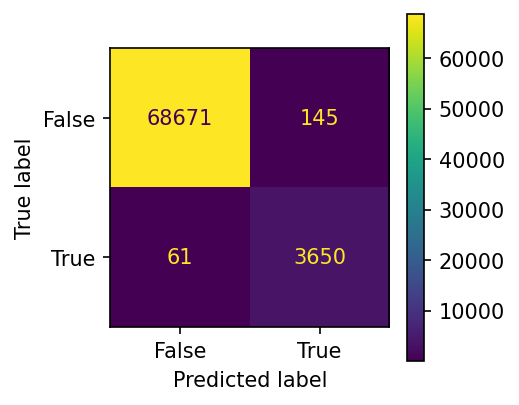

In [104]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=[False, True])
cm_display.plot()
plt.show()

In [112]:
random_search_rf.cv_results_

{'mean_fit_time': array([14.5573175 ,  7.34437594, 11.07952366,  9.34625473, 15.66315241,
        11.66967182,  7.73178706,  7.73551183,  7.24567943,  9.16486573]),
 'std_fit_time': array([0.25029253, 0.19008222, 0.19551459, 0.32272086, 0.33491434,
        0.25266388, 0.24354584, 0.40500554, 0.16154144, 0.2359713 ]),
 'mean_score_time': array([0.34712062, 0.25697312, 0.32318311, 0.25630574, 0.40817695,
        0.33881202, 0.27196479, 0.24533277, 0.24952946, 0.23029623]),
 'std_score_time': array([0.01270763, 0.00994473, 0.01233549, 0.01256165, 0.03678896,
        0.00416242, 0.04106742, 0.01114443, 0.01366213, 0.04096795]),
 'param_min_samples_leaf': masked_array(data=[2, 1, 3, 2, 3, 2, 3, 3, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt', 'log2', 'log2', 'log2', 'log2', 'sqrt', 'sqrt',
                    'log2', 's

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Logiestic regression is used for classification problems, espescially for binary classification problems. Since we're determining 1's and 0's as our target label in this scenerio I believe it would be a very well suited model to predict whether users would click on an ad. Since this model is essentially made for binary classification problems I predict it would have the best performing score out of the three. By default logistic regression uses the 'lbfgs' solver but the sklearn documentation stated that the 'sag' and 'saga' solvers are better choices for large datasets. The documents also mentioned 'newton-cholesky' as a good option for datasets where n_samples > n_features, especially features that are one-hot encoded and it is limited to binary classification. Thus, I decided to choose those three as my solver hyperparameter. As for the max_iter parameter, since the dataset is so large I run into the issue of the solvers not converging. By default the 'max_iter' hyperparameter is set to 100 but I made it 15000 to ensure it converges. 

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

params_lr = {"C":[0.01, 0.1, 1, 10, 100],
          "penalty":['l2'],
          "solver":['newton-cholesky', 'sag', 'saga'],
          "max_iter":[15000]
        }

lr_model = LogisticRegression()
random_search_lr = RandomizedSearchCV(lr_model, param_distributions=params_lr, n_iter=10, n_jobs=6, cv=5, verbose=1)
lr_results = random_search_lr.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [77]:
random_search_lr.best_score_

0.9935590232215233

In [91]:
random_search_lr.predict(X_test_scaled)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [92]:
#lr_score = random_search_lr.score(X_test_scaled, y_test)

In [105]:
best_lr_model = random_search_rf.best_estimator_

In [106]:
y_lr_pred = best_lr_model.predict(X_test)

In [108]:
lr_score = random_search_lr.score(X_test_scaled, y_test)

In [109]:
print(lr_score)

0.993312835219987


In [87]:
random_search_lr.best_estimator_

LogisticRegression(C=0.1, max_iter=15000, solver='newton-cholesky')

In [111]:
random_search_lr.cv_results_

{'mean_fit_time': array([3.13384948, 1.08945022, 1.78221617, 2.41679463, 2.36109362,
        3.1624752 , 1.25573888, 5.44762611, 1.50154071, 1.2707571 ]),
 'std_fit_time': array([0.12288432, 0.3562814 , 0.08711601, 0.18416298, 0.2380423 ,
        0.4545083 , 0.04168722, 0.32365455, 0.16618604, 0.07797046]),
 'mean_score_time': array([0.00540495, 0.005405  , 0.00500493, 0.00400405, 0.00400405,
        0.00400324, 0.00480456, 0.00400352, 0.00360327, 0.00380354]),
 'std_score_time': array([0.00080037, 0.00206092, 0.00126603, 0.00063301, 0.00063316,
        0.00109637, 0.00074927, 0.00063324, 0.00049051, 0.00040033]),
 'param_solver': masked_array(data=['saga', 'newton-cholesky', 'newton-cholesky', 'sag',
                    'sag', 'sag', 'newton-cholesky', 'saga', 'sag', 'saga'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l2', 'l2', 

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
params_svc = {"C": [0.1, 1, 10, 100], 
              "gamma": [1, 0.1, 0.01],
              "kernel": ['linear']} 

svc_model = SVC()
random_search_svc = RandomizedSearchCV(svc_model, param_distributions=params_svc, n_jobs=6, verbose=True)
random_search_svc.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=SVC(), n_jobs=6,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01],
                                        'kernel': ['linear']},
                   verbose=True)

In [58]:
random_search_svc.best_score_

0.9936062968620473

In [71]:
random_search_svc.predict(X_test_scaled)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [72]:
svc_score = random_search_svc.score(X_test_scaled, y_test)

In [73]:
print(svc_score)

0.9934093510003171


In [90]:
random_search_svc.best_estimator_

SVC(C=100, gamma=1, kernel='linear')

In [110]:
random_search_svc.cv_results_

{'mean_fit_time': array([5524.22719398,   32.34238825, 5491.35822048,   30.52792506,
         698.07444735,  110.61362534,   94.82412763, 4320.09228168,
         569.09825287,   90.20216098]),
 'std_fit_time': array([ 95.67382882,   1.95039935,  87.54958824,   1.60096362,
         19.97846715,   6.95541741,   4.74532237, 560.40613401,
         33.90854555,   5.65018165]),
 'mean_score_time': array([2.23689246, 2.26530657, 1.91878681, 2.15005274, 2.18044744,
        2.21281142, 1.97585101, 1.54058776, 1.80237513, 1.82459884]),
 'std_score_time': array([0.11910233, 0.13265615, 0.19005465, 0.10984764, 0.02641944,
        0.04097371, 0.1059777 , 0.25949242, 0.13224896, 0.07369646]),
 'param_kernel': masked_array(data=['linear', 'linear', 'linear', 'linear', 'linear',
                    'linear', 'linear', 'linear', 'linear', 'linear'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=o